In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [15]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [6]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'][2:], scaling['node_h'][2:], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [7]:
scaling = build_dataframe(x_axis='mpi', factor=20)
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
3   20     8      160      5         1        4         984.0   
6   40     8      320     10         1        4         536.0   
4   60     8      480     15         1        4         384.0   
0   80     8      640     20         1        4         315.0   
1  100     8      800     25         1        4         271.0   
7  120     8      960     30         1        4         247.0   
2  140     8     1120     35         1        4         209.0   
5  160     8     1280     40         1        4         203.0   

   io_ATMPROJ_pwscf  io_KB_abinit   io_BS  ...        Xo  DIPOLE_transverse  \
3            0.0000        0.0000  0.0001  ...  300.2192           579.7341   
6            0.0001        0.0001  0.0002  ...  168.6891           297.6945   
4            0.0001        0.0001  0.0002  ...  118.0636           205.3567   
0            0.0001        0.0001  0.0002  ...   91.1397           158.0147   
1            0.0001        0.0001  0.0002  ...   71.7884           130.2541   
7            0.0001        0.0001  0.0001  ...   64.6314           111.9596   
2            0.0001        0.0001  0.0002  ...   54.6259            97.3508   
5            0.0001        0.0001  0.0002  ...   47.5844            89.2600   

    Dipoles  gpu  ideal   speedup  efficiency  Self energy    Other    node_h  
3  582.2943    5    1.0  1.000000  100.000000      68.2428  26.1973  1.366667  
6  300.2903   10    2.0  1.835821   91.791045      34.6541  25.5010  1.488889  
4  208.4066   15    3.0  2.562500   85.416667      23.3646  31.3758  1.600000  
0  162.7750   20    4.0  3.123810   78.095238      18.5777  34.1820  1.750000  
1  135.9424   25    5.0  3.630996   72.619926      14.8844  41.8332  1.881944  
7  117.8433   30    6.0  3.983806   66.396761      12.8327  45.5991  2.058333  
2  100.1698   35    7.0  4.708134   67.259057      11.5566  38.7669  2.031944  
5   93.9510   40    8.0  4.847291   60.591133      10.4086  43.8974  2.255556  

[8 rows x 52 columns]

In [8]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile   Dipoles        Xo       X  Self energy    Other
3   20         984.0  582.2943  300.2192  7.0464      68.2428  26.1973
6   40         536.0  300.2903  168.6891  6.8655      34.6541  25.5010
4   60         384.0  208.4066  118.0636  2.7894      23.3646  31.3758
0   80         315.0  162.7750   91.1397  8.3256      18.5777  34.1820
1  100         271.0  135.9424   71.7884  6.5516      14.8844  41.8332
7  120         247.0  117.8433   64.6314  6.0935      12.8327  45.5991
2  140         209.0  100.1698   54.6259  3.8808      11.5566  38.7669
5  160         203.0   93.9510   47.5844  7.1586      10.4086  43.8974

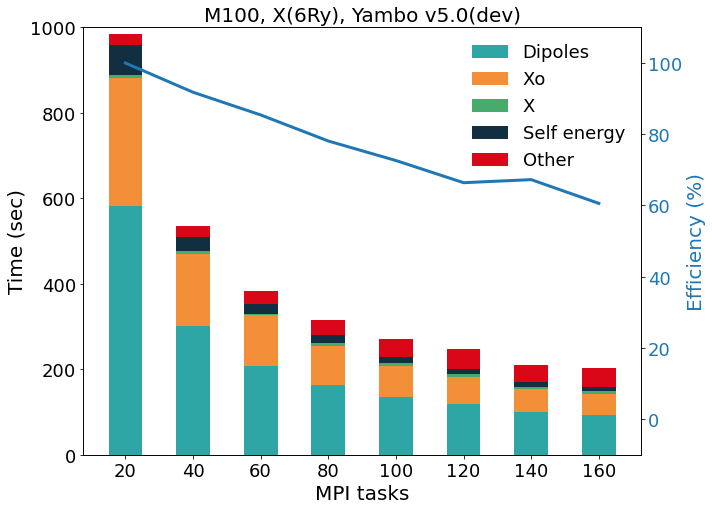

In [16]:
build_scaling_plot(scaling=scaling[scaling['mpi']>=20], 
                   pile=pile, colors=colors, bar_width=10, efficiency=True,
                   legend_loc='upper right', title=r'M100, X(6Ry), Yambo v5.0(dev)', 
                   file_name='scaling_5nodes.png', y_lim=[0,1000])

In [10]:
io_cols=['mpi', 'io_ATMPROJ_pwscf', 'io_KB_abinit', 'io_BS', 'io_Double_Grid', 'io_COL_CUT', 'PP_uspp_init', 'io_HF', 'IO_and_Messaging_switch', 'io_QINDX', 'io_KB_pwscf', 'io_DIPOLES', 'io_fragment', 'io_WF']
scaling[io_cols]

mpi  io_ATMPROJ_pwscf  io_KB_abinit   io_BS  io_Double_Grid  io_COL_CUT  \
3   20            0.0000        0.0000  0.0001          0.0002      0.0003   
6   40            0.0001        0.0001  0.0002          0.0008      0.0071   
4   60            0.0001        0.0001  0.0002          0.0026      0.0111   
0   80            0.0001        0.0001  0.0002          0.0021      0.0004   
1  100            0.0001        0.0001  0.0002          0.0035      0.0003   
7  120            0.0001        0.0001  0.0001          0.0011      0.0004   
2  140            0.0001        0.0001  0.0002          0.0010      0.0003   
5  160            0.0001        0.0001  0.0002          0.0078      0.0003   

   PP_uspp_init   io_HF  IO_and_Messaging_switch  io_QINDX  io_KB_pwscf  \
3        0.0006  0.0223                   0.0005    0.0053       0.4134   
6        0.0006  0.0227                   0.0005    0.0322       0.2907   
4        0.0007  0.0242                   0.0005    0.0269       0.3551   
0        0.0008  0.0239                   0.0005    0.0264       0.2707   
1        0.0010  0.0226                   0.0005    0.0074       0.3951   
7        0.0007  0.0258                   0.0005    0.0186       0.4221   
2        0.0007  0.0234                   0.0005    0.0062       0.3276   
5        0.0008  0.0395                   0.0005    0.0178       0.4498   

   io_DIPOLES  io_fragment    io_WF  
3      1.2631       1.4253  10.7221  
6      1.2526       1.2499   7.3285  
4      1.2824       1.5005   5.6649  
0      1.2174       1.0668   4.9759  
1      1.1875       1.1679   4.5199  
7      1.1405       1.4336   4.2144  
2      1.3039       0.8561   3.0165  
5      2.7161       3.1497   3.6317